## Style guides (remove before submitting)
1. PEP8 for python: https://peps.python.org/pep-0008
2. for jupyter notebook: https://github.com/spacetelescope/style-guides/blob/master/guides/jupyter-notebooks.md

## General TODO (remove before submitting)
1. Maybe add Raise errors?

## DOCSTRING convention example (according to Pep8) (remove before submitting)
**Short docstrings:**\
"""This is an example of a short docstring."""\
\
**Long docstrings:**\
"""\
Short description of the function (may be next to quotations above).\
\
Arguments:\
    parametername: What the parameter is\
    parametername2: what the parameter is\
\
Returns:\
    This is a description of what the function returns.\
"""

# Gillespie's Algorithm and Stochasticity in a SIR model

This code implements a Gillespie's algorithm (GA) to a SIR model where stochasticity is introduced.  

#### SIR Model
A SIR model is a description of the behavioral patterns of infectious disseases with the help of a set of Ordinary Differential Equations (ODEs). Depending on the dissease that's being modeled, there are different types of SIR models that can be implemented. The model that we use is divided into three categories:

1.  Susceptible; A group within the population that is susceptible to infection with the dissease.
2.  Infected; A group within the population that is currently infected with the dissease
3.  Recovered; A group that has recovered from an infection, we assume they cannot be infected again

The rate with which people transfer between these categories is described by parameters. The parameters we use are called the infection rate (beta) and recovery rate (gamma) that describe the flow of susceptible to infected (beta) and of infected to recovered (gamma). Additionally, birth and death rates are introduced to describe the effect of 'fresh' additions to the population to the susceptible pool and a chance of mortality at each category.

The set of ODEs describe how the populations within these categories change over time due to the applied parameters. 

### Gillespie's Algorithm
A Gillespie's Algorithm (GA) stochastically simulates discrete events from the equation it is applied to. In our application we used the so-called First Reaction Method where the rate at which an event occurs is passed to calculate how long it takes for the event to occur. To this determination, a random variable is attached to add stochasticity. The event that takes the least amount of time to occur is then executed, all other events are negated. The time that passed is updated to include the time it took for the event to occur and a new event is generated. This is repeated until the predetermined end-point is reached (such as an established end-time).

- TO DO: 
    - add ODE functions
    - add GA function 







## Imports

The following libraries where imported for further use in the code

* tabulate for ...
* numpy for use in numerical computing
* matplotlib for visualisation of data in plots
* pandas for ...
* fractions for ...
* solve_ivp for numerical integration of the SIR ODE functions
* bisect for ...

- TO DO:
    - Add explanations
    - Remove unused imports

In [16]:
import bisect
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import operator

from scipy.integrate import solve_ivp
from scipy import stats

import networkx as nx
import ndlib.models.ModelConfig as mc
import ndlib.models.epidemics as ep
import ndlib.models.DiffusionModel as dm

np.random.seed(30) 

# Stochasticity in a SIR model

## 1. Making a Stochastig SIR Model

### 1.1 Define All Possible Events 

In order to update the stochastic GSP SIR model, the sir_update() function is given a key which it uses to identify and update the according S, I, R and or N populations. 
In this model, we approach the population as individuals, not scaled to percentages. Therefore, updates regard a single individual and only adjust the affected populations.

By using if and elif statements, we prevent the function from accessing all if statements as there will always only be one key. If an if statement is accessed, it will return the updated S, I, R and N values.


In [2]:
def sir_update(S, I, R, N, key):
    """Updates and returns SIRN populations according to given key."""

    if key == 'infection':
        S -= 1
        I += 1
        return S, I, R, N
    
    elif key == 'recovery': 
        R += 1
        I -= 1
        return S, I, R, N
    
    elif key == 'birth':
        S += 1
        N += 1
        return S, I, R, N
    
    elif key == 'death S':
        S -= 1
        N -= 1
        return S, I, R, N
    
    elif key == 'death I':
        I -= 1
        N -= 1
        return S, I, R, N
    
    elif key == 'death R':
        R -= 1
        N -= 1
        return S, I, R, N

### 1.2 Implement GSP 

A random exponantial is assigned to each available event, allowing events occur only if the neccesary populations (S, I, R) have individuals. An event queue dictionary is initiated to store all possible events and their time of occurence, sorted in descending order. 

The simulation iterates by executing the first event in the queue, updating the SIR model parameters and adding the event's occurence time to the total elapsed time. After executing an event, the queue is cleared and reinitialized for the next cycle.

This process continues until the elapsed time meets or exceeds a specified duration. The function returns the sizes of S, I, R, N as y_data along with the total simulation time



- Add a way to control noise level (gsp function)
    - Larger N reduces noise
    - average results on multiple simulations
    - reduce noise after simultaion: remove high frequency fluctuations

In [3]:
def gsp(sir, beta, gamma, mu, end):
    """
    Simulates disease spread using GA First Reaction Method.

    Arguments:
        sir: List of S, I, R and N populations.
        beta: Infection rate.
        gamma: Recovery rate.
        mu: Natural birth and death rate.
        end: Signifies end point of simulation in time.

    Returns:
        A tuple containing a list of time events and population data 
        over time.
    """

    S, I, R, N = sir
    t = 0
    
    t_events = []
    y_data = []
    
    while t <= end:
        
        # This queue collects the delta_t of each event at time t + delta_t
        event_queue = {}

        if S > 0 and I > 0 and N > 0:
            dt_infection = np.random.exponential(1/(beta*S*I/N))
            event_queue['infection'] = dt_infection

        if I > 0:
            dt_recovery = np.random.exponential(1/(gamma*I))
            event_queue['recovery'] = dt_recovery

        if N > 0:
            dt_birth = np.random.exponential(1/(mu*N))
            event_queue['birth'] = dt_birth

        if S > 0:
            dt_death_S = np.random.exponential(1/(mu*S))
            event_queue['death S'] = dt_death_S

        if I > 0:
            dt_death_I = np.random.exponential(1/(mu*I))
            event_queue['death I'] = dt_death_I

        if R > 0:
            dt_death_R = np.random.exponential(1/(mu*R))
            event_queue['death R'] = dt_death_R

        # Select the event with the smallest delta_t, this event will be carried out, the rest is omitted
        sorted_queue = dict(sorted(event_queue.items(), 
                                   key=lambda item: item[1]))
        first_event_key, first_event_time = list(sorted_queue.items())[0]
        
        # Updates the current time with delta_t
        t += first_event_time
        t_events.append(t)

        # Handle each type of event
        S, I, R, N = sir_update(S, I, R, N, first_event_key)

        y_data.append([S, I, R])
    
    return (t_events, y_data)

### 1.3 Run Stochastic Simulation

The function run_gsp_simulation() visualizes the data from the stochastic SIR model simulation above. By running the gsp() function, the neccesary data is unpacked into S, I and R and plotted. The figure indicates the change in population sizes over time. 

In [6]:
def run_gsp_simulation(sir, beta, gamma, mu, t_span):
    """
    Runs the GA stochastic disease simulation and plots the results.

    Arguments:
        sir: List of S, I, R and N populations.
        beta: Infection rate.
        gamma: Recovery rate.
        mu: Natural birth and death rate.
        t_span: Maximum duration of the GA simulation.
    """

    t_events, y_data = gsp(sir, beta, gamma, mu, t_span)

    y_data = np.array(y_data)

    S = y_data[:, 0]
    I = y_data[:, 1]
    R = y_data[:, 2]

    plt.figure(figsize=(6, 4))
    plt.plot(t_events, S, label='Susceptible (S)', color='blue')
    plt.plot(t_events, I, label='Infected (I)', color='orange')
    plt.plot(t_events, R, label='Recovered (R)', color='green')
    plt.xlabel('Time')
    plt.ylabel('Population')
    plt.title('Disease Simulation Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()



### 1.4 Parameters 

Parameters to the gsp model are initialized and passed to run the gsp simulation function. The parameters are kept seperately such that they may be changed with ease.
The total population is chosen after which the other populations, Susceptible (S), Infected (I), and Recovered (R), are adjusted accordingly 

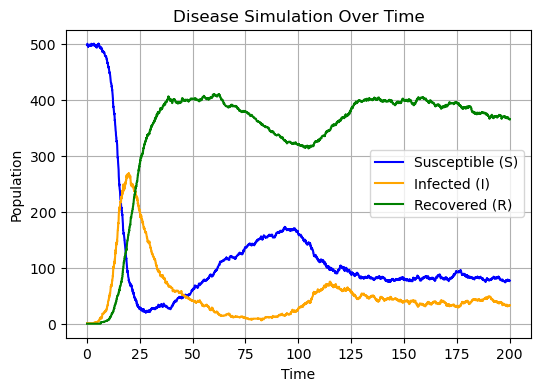

In [17]:
# Intitial population sizes
N = 500
S = N - 1
I = N - S
R = 0
sir = [S, I, R, N]

# Parameters for infection, recovery and death rate
beta = 0.6
gamma = 0.1
mu = 0.01
parameters = [beta, gamma, mu]

timespan = 200

run_gsp_simulation(sir, beta, gamma, mu, timespan)

## 2. Making a Deterministic SIR Model

A SIR model as created in the previous assignment is imported to analyze the difference between a deterministic and stochastic model. For clarity, all parameters are initiated again.

TO DO: How much do we need to explain this?


- Add similarity score between stochastic and derministic model.

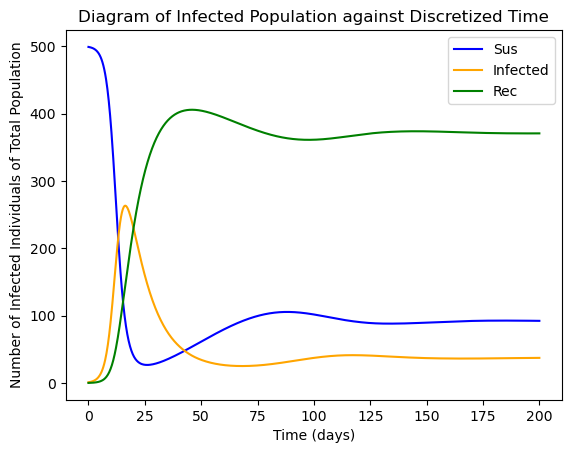

In [11]:
def calc_ode(t, sir, parameters, N):
    """Calculates and returns the change in sir populations over time."""
    
    beta, gamma, mu = parameters
    S, I, R = sir

    dSdt = (mu*N) - ((beta*S*I)/N) - (mu*S)
    dIdt = ((beta*S*I)/N) - (gamma*I) - (mu*I)
    dRdt = (gamma*I) - (mu*R)

    return [dSdt, dIdt, dRdt]


def run_sir_det(sir, parameters, N, t_span):
    """Runs the deterministic sir model with passed initial values.
    
    Arguments:
        sir: List of S, I, R and N populations.
        parameters: list containg recovery, infection and 
                    birth/death rate
        N: Total initial population
        t_span: Timespan in which the model is ran

    Returns: 
        Timespan used to model sir and population sizes of S, I and R.
    """

    # Time measurement with 1000 samples, equally spaced between 0 and t_span
    time = np.linspace(0, t_span, 1000)

    sir_integration = solve_ivp(calc_ode, [time[0], time[-1]], sir, 
                                args=(parameters, N), t_eval=time)
    S, I, R = sir_integration.y

    return time, S, I, R


def plot_sir_det(time, S, I, R):
    """Plots the deterministic sir model."""

    plt.plot(time, S, label='Sus', color='b')
    plt.plot(time, I, label='Infected', color='orange')
    plt.plot(time, R, label='Rec', color='g')
    plt.xlabel('Time (days)')
    plt.ylabel('Number of Infected Individuals of Total Population')
    plt.legend()
    plt.title('Diagram of Infected Population against Discretized Time')
    plt.show()
    

# Intitial population densities
N = 500
S0 = N - 1
I0 = N - S0
R0 = 0
sir_det = [S0, I0, R0]

# Parameters for infection, recovery and death rate
beta = 0.6
gamma = 0.1
mu = 0.01
parameters = [beta, gamma, mu]

t_span = 200

# The semi-colon prevents the array from being printed in cell
time, S, I, R = run_sir_det(sir_det, parameters, N, t_span);
plot_sir_det(time, S, I, R)

## 3. Analyzing stochasticity

### 3.1 Look at variance

TODO MARVIN
- write short python notebook since you made this one mostly, easier for you to do it

- Plot results

- Delete print statements (not yet)

Beta/gamma pairs: [(0.010000000000000002, 0.1), (0.020891295293627654, 0.1163265306122449), (0.03438150770512287, 0.1326530612244898), (0.050470637234485624, 0.1489795918367347), (0.06915868388171596, 0.1653061224489796), (0.09044564764681383, 0.1816326530612245), (0.11433152852977925, 0.1979591836734694), (0.14081632653061227, 0.2142857142857143), (0.1699000416493128, 0.2306122448979592), (0.2015826738858809, 0.2469387755102041), (0.23586422324031658, 0.263265306122449), (0.2727446897126197, 0.2795918367346939), (0.3122240733027905, 0.29591836734693877), (0.35430237401082887, 0.3122448979591837), (0.3989795918367348, 0.3285714285714286), (0.4462557267805081, 0.3448979591836735), (0.4961307788421491, 0.36122448979591837), (0.5486047480216576, 0.37755102040816324), (0.6036776343190338, 0.3938775510204082), (0.6613494377342775, 0.4102040816326531), (0.7216201582673887, 0.42653061224489797), (0.7844897959183673, 0.44285714285714284), (0.8499583506872138, 0.4591836734693878), (0.9180258225

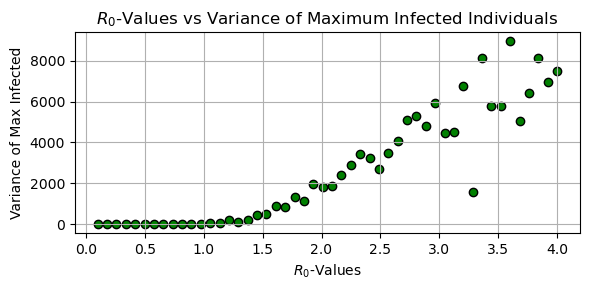

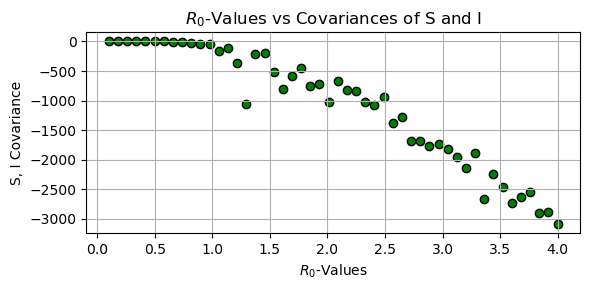

In [32]:
np.random.seed(23)

def generate_parameters(num_samples, R0_range=(0.1, 4.0), gamma_range=(0.1, 0.9)):
    """
    Generates systematic beta and gamma pairs such that the R0 values range within a specified range.
    Gamma values are generated within the specified range, and beta values are calculated accordingly.
    
    Parameters:
        num_samples (int): Number of beta/gamma pairs to generate.
        R0_range (tuple): Desired range for R0 values.
        gamma_range (tuple): Range for generated gamma values.
    
    Returns:
        list: List of (beta, gamma) pairs.
        list: List of R0 values.
    """
    
    R0_vals = np.linspace(R0_range[0], R0_range[1], num_samples)
    
    gammas = np.linspace(gamma_range[0], gamma_range[1], num_samples)
    
    betas = R0_vals * gammas
    
    beta_gamma_pairs = list(zip(betas, gammas))

    # Optional: print for debugging
    print("Beta/gamma pairs: " + str(beta_gamma_pairs))
    print("R0 values: " + str(R0_vals))
    
    return beta_gamma_pairs, R0_vals


def parameter_sweep(sir, pairs, mu, num_runs):
    """
    Performs a parameter sweep over the SIR model simulation to analyze 
    the impact of varying beta and gamma values on the maximum number of 
    infected individuals.

    Arguments:
        sir: List of S, I, R and N populations.
        pairs: List of beta-gamma tuples to test in SIR model.
        mu: Natural birth and death rate.
        num_runs: Number of simulation runs per beta-gamma pair tuples.
    
    Returns:
        A list of variances and covariances of the maximum infected 
        values for each beta-gamma pair.
    """
    
    variances = []
    covariances = []

    for beta, gamma in pairs:
        
        # For variance
        max_I_vals = []

        # For covariance
        S_vals= []
        I_vals = []
        
        # Run simulation n times for each (beta, gamma) pair.
        for _ in range(num_runs):

            result = gsp(sir, beta, gamma, mu, t_span)
            y_data = np.array(result[1])

            S = y_data[:, 0]
            I = y_data[:, 1]
            R = y_data[:, 2]

            S_vals.extend(S)
            I_vals.extend(I)

            # Extract max I value from each run.
            max_I_vals.append(np.max(I))

        # Variance for each (beta, gamma) pair after n runs is recorded.
        variances.append(np.var(max_I_vals))
        covariance_matrix = np.cov(S_vals, I_vals)
        covariances.append(covariance_matrix[0, 1])

    return variances, covariances


def plot_R0_vs_variance(R0_vals, variances):
    """
    Plots R0 values against variances of maximum infected individuals.
    """

    plt.figure(figsize=(6, 3))
    plt.scatter(R0_vals, variances, color='green', edgecolor='black')

    plt.xlabel(r'$R_0$-Values')
    plt.ylabel('Variance of Max Infected')
    plt.title(r'$R_0$-Values vs Variance of Maximum Infected Individuals')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('R0vsvar.png', dpi=150)
    plt.show()


def plot_R0_vs_covariances(R0_vals, covariances):
    """
    Plots R0 values against covariances of S and I across different 
    parameter pairs.
    """

    plt.figure(figsize=(6, 3))
    plt.scatter(R0_vals, covariances, color='green', edgecolor='black')

    plt.xlabel(r'$R_0$-Values')
    plt.ylabel('S, I Covariance')
    plt.title(r'$R_0$-Values vs Covariances of S and I')
    #plt.axhline(0, color='gray', linestyle='--')  # Optional: Add a horizontal line at y=0
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('R0vscovar.png', dpi=150)
    plt.show()


# Define number of beta/gamma pairs.
num_pairs = 50

# Define number of runs per beta/gamma pair.
num_runs = 20

# Generate Parameters
sample_pairs, sample_R0_vals = generate_parameters(num_pairs)

# Calculate variances
variances, covariances = parameter_sweep(sir, sample_pairs, mu, num_runs)

# Combine and sort by R0 for variance analysis
var_combined = list(zip(sample_R0_vals, variances))
sorted_var_combined = sorted(var_combined)
sorted_R0_vals, sorted_variances = zip(*sorted_var_combined)

# Combine and sort by R0 for variance analysis
covar_combined = list(zip(sample_R0_vals, covariances))
sorted_covar_combined = sorted(covar_combined)
sorted_R0_vals, sorted_covariances = zip(*sorted_covar_combined)

plot_R0_vs_variance(sorted_R0_vals, sorted_variances)
plot_R0_vs_covariances(sorted_R0_vals, sorted_covariances)

### 3.2 Calculate the Mean

Since a stochastic simulation may render more extremes, we wanted to calculate and visualizes a mean for the stochastic SIR model to compare with the deterministic model. 

However, every gsp run may result in different time steps. Therefore we had to initialize dictionaries to store variables for each run at fixed steps. These steps were chosen by starting at t = 0 and ending at t = timespan. Here the timespan equals the timespan used for the gsp function. Steps were taken with equal spacing.

For every gsp mean, the values of S, I and R (and N) at these specific time steps was saved. This was done by iterating over the list of fixed_steps and finding the S, I, R and N values at that point in time. The corresponding values are then stored in a dictionary with fixed_steps. This will eventually result in a dictionary with fixed time steps and values for S, I, R and N at each of those fixed steps. The amount of values at each step depends on how often the stochastic sir simulation was performed.

The mean and std of each time step is then calculated and stored in seperate dictionaries.


Since the steps at which S, I and R are recorded in the mean may differ from the fixed_steps that we determined, the lowest closest value was chosen and the S, I and R values were placed to the right of that value on the timeline
TO DO: FRED
- TO DO: change deterministic to roll with same parameters ?

In [ ]:
def gsp_mean(runs, t_span, sir, parameters):
    """
    This function runs the gsp SIR model a set number of times to 
    calculate the mean and standard deviation the runs.

    Arguments:
        runs: Number of times to run the gsp function
        t_span: Lower bound for the ratio of R0 values.
        sir: List of S, I, R and N populations.
        parameters: list containg recovery, infection and 
                    birth/death rate
    
    Returns:
        Dictionaries with information stored of the results, mean and 
        standard deviation of each time step. Also returns a list of 
        maximum I values for each run.
    """

    beta, gamma, mu = parameters

    # calculates how large the steps should be in between time steps    
    t_steps = t_span/ 1000
 
    # end excludes end so include t_steps. steps are spacing between values
    fixed_steps = np.round(np.arange(0, t_span + t_steps, t_steps), 2)

    # store data from run at those fixed time steps 
    results = {
        'time': fixed_steps.tolist(),
        'S': {round(step, 4): [] for step in fixed_steps},
        'I': {round(step, 4): [] for step in fixed_steps},
        'R': {round(step, 4): [] for step in fixed_steps},
        'N': {round(step, 4): [] for step in fixed_steps}
        }
    
    results_mean = {
        'S': [],
        'I': [],
        'R': [],
        'N': []
        }
    
    results_stdev = {
        'S': [],
        'I': [],
        'R': [],
        'N': []
        }

    # Stores the peak number of Infected and equivalent timepoints for every run
    peak_infected = []

    I_max = 0
    t_max = 0

    for _ in range(runs):
        t_events , y_data = gsp(sir, beta, gamma, mu, t_span)

        I_max = 0
        t_max = 0

        # Finds for which values of steps in fixed_steps what the closest (lower) is in t_events.
        for steps in fixed_steps:
            steps = round(steps, 4)

            # Returns where a value should be inserted
            position_value = bisect.bisect_right(t_events, steps)

            # Find the closest lowest possible position value
            if position_value > 0:
                position_value -= 1

            # Get the S, I and R data at that position
            S, I, R = y_data[position_value]

            if I > I_max:
                I_max = I
                t_max = t_events[position_value]

            # Appends the corresponding values to the correct place on the timeline
            results['S'][steps].append(S)
            results['I'][steps].append(I)
            results['R'][steps].append(R)
            results['N'][steps].append(S + I + R)
            
        peak_infected.append([t_max, I_max])

    # Access all entries for S, I , R and N in the fixed steps and store mean values in a dictionary
    for steps in fixed_steps:
        
        results_mean['S'].append(np.mean(results['S'][steps]))
        results_mean['I'].append(np.mean(results['I'][steps]))
        results_mean['R'].append(np.mean(results['R'][steps]))
        results_mean['N'].append(np.mean(results['N'][steps]))

        results_stdev['S'].append(np.std(results['S'][steps]))
        results_stdev['I'].append(np.std(results['I'][steps]))
        results_stdev['R'].append(np.std(results['R'][steps]))
        results_stdev['N'].append(np.std(results['N'][steps]))
    
    return results, results_mean, results_stdev, peak_infected


def plot_mean(results, results_mean, sir):
    """
    Visualizes the results from the gsp_mean function as changes in 
    population sizes over time.
    """
   
    S, I, R, N = sir
    sir_det = [S, I, R]

    S_mean = results_mean['S']
    I_mean = results_mean['I']
    R_mean = results_mean['R']
    time = results['time']

    time_2, S, I, R = run_sir_det(sir_det, parameters, N, t_span)
    
    plt.plot(time, S_mean, label='S mean', color='blue')
    plt.plot(time, I_mean, label='I mean', color='red')
    plt.plot(time, R_mean, label='R mean', color='green')
    plt.plot(time_2, S, label='S deterministic', color='blue', 
             linestyle='dashed')
    plt.plot(time_2, I, label='I deterministic', color='red', 
             linestyle='dashed')
    plt.plot(time_2, R, label='R deterministic', color='green', 
             linestyle='dashed')

    time_steps_S = []
    time_steps_I = []
    time_steps_R = []
    S_values = []
    I_values = []
    R_values = []

    for time_step, values in results['S'].items():
        for value in values:
            time_steps_S.append(time_step)
            S_values.append(value)
    
    for time_step, values in results['I'].items():
        for value in values:
            time_steps_I.append(time_step)
            I_values.append(value)

    for time_step, values in results['R'].items():
        for value in values:
            time_steps_R.append(time_step)
            R_values.append(value)

    plt.scatter(time_steps_S, S_values, alpha=0.03, linewidths=0, 
                color='blue', marker='o', label='S values', s=1)
    plt.scatter(time_steps_I, I_values, alpha=0.03, linewidths=0, 
                color='red', marker='o', label='I values', s=1)
    plt.scatter(time_steps_R, R_values, alpha=0.03, linewidths=0, 
                color='green', marker='o', label='R values', s=1)

    plt.xlabel('Time (days)')
    plt.ylabel('Mean Number of Infected Individuals of Total Population')
    plt.legend()
    plt.title('Diagram of Population against Discretized Time (mean)')
    plt.show()

    return


# Intitial population sizes
N = 500
S = N - 1
I = N - S
R = 0
sir = [S, I, R, N]

# Parameters for infection, recovery and death rate
beta = 0.6
gamma = 0.1
mu = 0.05
parameters = [beta, gamma, mu]

t_span = 100
runs = 100

results, results_mean, results_stdev, _ = gsp_mean(runs, t_span, sir, parameters);
plot_mean(results, results_mean, sir)

### 3.3 R0 vs Extinction Events

TODO: MARVIN

Beta/gamma pairs: [(0.11000000000000001, 0.1), (0.13052631578947368, 0.1), (0.15105263157894738, 0.1), (0.17157894736842105, 0.1), (0.19210526315789475, 0.1), (0.21263157894736848, 0.1), (0.23315789473684215, 0.1), (0.25368421052631585, 0.1), (0.2742105263157895, 0.1), (0.2947368421052632, 0.1), (0.3152631578947369, 0.1), (0.3357894736842106, 0.1), (0.35631578947368425, 0.1), (0.3768421052631579, 0.1), (0.3973684210526316, 0.1), (0.4178947368421053, 0.1), (0.438421052631579, 0.1), (0.45894736842105266, 0.1), (0.47947368421052633, 0.1), (0.5, 0.1)]
R0 values: [1.1        1.30526316 1.51052632 1.71578947 1.92105263 2.12631579
 2.33157895 2.53684211 2.74210526 2.94736842 3.15263158 3.35789474
 3.56315789 3.76842105 3.97368421 4.17894737 4.38421053 4.58947368
 4.79473684 5.        ]
0.0
0.8666666666666667
0.0
0.0
0.0
0.1
0.3
14.024038461538462
0.0
0.25925925925925924
0.2
0.0
0.0
0.2
0.0
1.2173913043478262
0.2962962962962963
0.045454545454545456
0.038461538461538464
0.13043478260869565
0.0


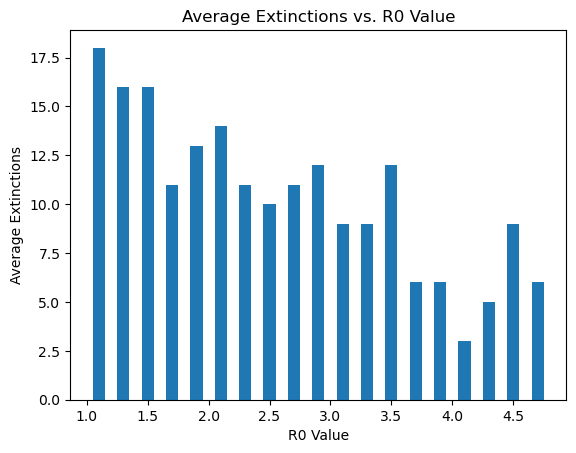

In [30]:
def generate_large_R0(num_samples, R0_range=(1.1, 5), gamma_value=0.1):
    """
    Generates systematic beta and gamma pairs such that the R0 values range from 1.1 to 5.
    
    Parameters:
        num_samples (int): Number of beta/gamma pairs to generate.
        R0_range (tuple): Range for R0 values.
        gamma_value (float): Fixed value for gamma (to systematically calculate beta).
    
    Returns:
        list: List of (beta, gamma) pairs.
        list: List of R0 values.
    """
    
    # Generate evenly spaced R0 values within the specified range
    R0_vals = np.linspace(R0_range[0], R0_range[1], num_samples)
    
    # Use a fixed gamma value, and calculate corresponding beta = R0 * gamma
    gammas = np.full(num_samples, gamma_value)
    betas = R0_vals*gammas  # beta = R0 * gamma

    beta_gamma_pairs = list(zip(betas, gammas))

    # Optional: print for debugging
    print("Beta/gamma pairs: " + str(beta_gamma_pairs))
    print("R0 values: " + str(R0_vals))
    
    return beta_gamma_pairs, R0_vals


def count_R0_extinctions(pairs, num_runs):
    """."""

    extinction_list = []

    for beta, gamma in pairs:
        num_extinctions = 0
    
        for _ in range(num_runs):
                result = gsp(sir, beta, gamma, mu, t_span)
                y_data = np.array(result[1])

                I = y_data[:, 1]

                mean = np.mean(I)
                print(mean)

                if mean < 1e-2:  # Treat any value below a small threshold as extinction:
                    num_extinctions += 1

        extinction_list.append(num_extinctions)

    return extinction_list
        

def plot_results_R0(num_pairs, num_runs):
    """."""
    
    sample_pairs, sample_R0_vals = generate_large_R0(num_pairs)
    R0_extinctions = count_R0_extinctions(sample_pairs, num_runs)

    # Sort R0 values and corresponding extinctions
    R0_extinction_pairs = list(zip(sample_R0_vals, R0_extinctions))
    sorted_R0_extinction_pairs = sorted(R0_extinction_pairs)

    sorted_R0_vals, sorted_extinctions = zip(*sorted_R0_extinction_pairs)

    # Convert to numpy arrays for easy indexing
    sorted_R0_vals = np.array(sorted_R0_vals)
    sorted_extinctions = np.array(sorted_extinctions)

    # Bin the R0 values (for example, in intervals of 0.1)
    bins = np.arange(min(sorted_R0_vals), max(sorted_R0_vals), 0.2)
    bin_indices = np.digitize(sorted_R0_vals, bins)

    # Average extinctions within each bin
    binned_extinctions = [np.mean(sorted_extinctions[bin_indices == i]) 
                          for i in range(1, len(bins))]

    # Plotting
    plt.bar(bins[:-1], binned_extinctions, width=0.1)
    plt.xlabel("R0 Value")
    plt.ylabel("Average Extinctions")
    plt.title("Average Extinctions vs. R0 Value")
    plt.show()


# ADD BLOCKNOTE
num_pairs = 20
num_runs = 50
mu = 0.0001

plot_results_R0(num_pairs, num_runs)

### 3.4 N vs Extinction Events

TODO MARVIN

In [ ]:
def generate_populations(num_pops):
    """."""

    populations = []
    
    # Evenly distributes populations from 100 to 10,000.
    S_0 = np.linspace(100, 10000, num_pops)

    for i in range(num_pops):
        S = S_0[i]
        I = 1
        R = 0
        N = S + I
        sir = (S, I, R, N)
        populations.append(sir)
    
    return populations


def count_N_extinctions(num_pops, num_runs):
    """."""

    populations = generate_populations(num_pops)
    extinction_list = []

    for pop in populations:
        num_extinctions = 0
        for _ in range(num_runs):
            result = gsp(pop, beta, gamma, mu, t_span)
            y_data = np.array(result[1])
            I = y_data[:, 1]
            mean = np.mean(I)

            # Treats any value below a small threshold as extinction.
            if mean < 1e-3:
                num_extinctions += 1
        
        extinction_list.append(num_extinctions)
    
    return extinction_list


def plot_results_N(num_pops, num_runs):
    """."""
    
    sample_pops = generate_populations(num_pops)
    N_extinctions = count_N_extinctions(num_pops, num_runs)

    # Sorts population sizes and corresponding extinctions.
    N_extinction_pairs = list(zip(sample_pops, N_extinctions))
    sorted_N_extinction_pairs = sorted(N_extinction_pairs)

    sorted_pops, sorted_extinctions = zip(*sorted_N_extinction_pairs)

    # Convert to numpy arrays for easy indexing
    sorted_pops = np.array(sorted_pops)
    sorted_extinctions = np.array(sorted_extinctions)

    # Bin the population sizes more sensibly with a larger bin size
    bins = np.arange(min(sorted_pops[:, 0]), max(sorted_pops[:, 0]) + 1, 300)  # Increase bin size to 1000
    bin_indices = np.digitize(sorted_pops[:, 0], bins)

    # Average extinctions within each bin
    binned_extinctions = [np.mean(sorted_extinctions[bin_indices == i]) for i in range(1, len(bins))]

    # Plotting
    plt.bar(bins[:-1], binned_extinctions, width=np.diff(bins), align='edge')
    plt.xlabel("N")
    plt.ylabel("Average Extinctions")
    plt.title("Average Extinctions vs. N (with adjusted bin size)")
    plt.show()


# Parameters
beta = 0.4
gamma = 0.1
mu = 0.0001

num_pops = 20
num_runs = 50

plot_results_N(num_pops, num_runs)

### 3.5 Extinctions as a Function of R0 and N

TODO MARVIN

In [ ]:
def plot_results_R0_N(num_pairs, num_pops, num_runs):
    """."""

    # Generate R0 pairs
    sample_pairs, sample_R0_vals = generate_large_R0(num_pairs)

    # Generate populations
    populations = generate_populations(num_pops)

    # Count extinctions for each combination of R0 and N
    extinction_data = []

    for (beta, gamma), R0 in zip(sample_pairs, sample_R0_vals):
        
        for pop in populations:
            num_extinctions = 0
            
            for _ in range(num_runs):
                result = gsp(pop, beta, gamma, mu, t_span)
                y_data = np.array(result[1])
                I = y_data[:, 1]
                mean = np.mean(I)
                
                if mean < 1e-2:  # Treat any value below a small threshold as extinction
                    num_extinctions += 1

            # Store results: (N, R0, num_extinctions)
            N = pop[0] + pop[1] + pop[2]  # S + I + R
            extinction_data.append((N, R0, num_extinctions))

    # Convert to numpy array for easier indexing
    extinction_data = np.array(extinction_data)

    # Separate the data for plotting
    N_values = extinction_data[:, 0]
    R0_values = extinction_data[:, 1]
    extinction_counts = extinction_data[:, 2]

    # Create a 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    scatter = ax.scatter(N_values, R0_values, extinction_counts, c=extinction_counts, cmap='viridis')
    
    ax.set_xlabel('Population Size (N)')
    ax.set_ylabel('R0 Value')
    ax.set_zlabel('Number of Extinctions')
    ax.set_title('Interaction between R0 and N in Extinctions')

    cbar = plt.colorbar(scatter)
    cbar.set_label('Number of Extinctions')

    plt.show()


# Parameters
num_pairs = 20
num_pops = 20
num_runs = 20
mu = 0.0001

# Execute the plotting function
plot_results_R0_N(num_pairs, num_pops, num_runs)

### 3.6 Stochastic Resonance

TODO FRED

Might have to redo see pic max


In [ ]:
def stoc_res_R0(num_samples, R0_range=(1, 10), gamma_value=0.1):
    """R0 values is a list of n_samples R0 and beta of n_sample amount, gamma equal."""
    
    R0_values = np.round(np.linspace(R0_range[0], R0_range[1], num_samples), 2)
    
    beta_values = []
    gamma_values = []

    for value in R0_values:
        beta_values.append(np.round((value * gamma_value), 2))
        gamma_values.append(gamma_value)

    beta_gamma_pairs = list(zip(beta_values, gamma_values))

    return beta_gamma_pairs


def stoc_res(sir, t_span, num_samples, mu):
    """
    Peak infected and peak_det are lists containing all sets of peak 
    infected values.
    """

    beta_gamma_pairs = stoc_res_R0(num_samples)

    peak_det = []
    bg = []
    snr = []
    mean_time = []
    stdev_time = []

    for beta, gamma in beta_gamma_pairs:
        parameters = [beta, gamma, mu]
        runs_stoc = 10
        _, _, _, peak_infected = gsp_mean(runs_stoc, t_span, sir, parameters)

        # Calculates the mean and stdev for peak infected time in gsp
        time = [t[0] for t in peak_infected]
        mean_time.append(np.mean([time]))
        mean_time_gsp = np.mean([time])
        stdev_time.append(np.std([time]))
        
        # Unpacks and reassign sir for deterministic model.
        S, I, R, N = sir
        sir_det = S, I , R
        time_det, _, I_det, _ = run_sir_det(sir_det, parameters, N, 
                                                    t_span)

        # Finds maximum values for deterministic model and stores them.
        I_max = max(I_det)
        t_max_index = np.where(I_det == I_max)
        t_max = time_det[t_max_index][0]
        peak_det.append([t_max])

        bg.append(beta/gamma)
        snr.append(t_max/ mean_time_gsp)


    # have peaks for det
    # have peaks for gsp mean
    # have peaks for gsp stdev
    return mean_time, stdev_time, peak_det, bg, snr

def plot_stoc_peak(mean_time, peak_det, bg):
    """
    TO DO: possibly add stdev error bars, substract mean det from mean 
    gsp, but will go into 0."""

    plt.plot(bg, peak_det, label='peak I time det', color='green')
    plt.plot(bg, mean_time, label='peak I time stoc', color='blue')
    plt.xlabel('R0')
    plt.ylabel('Time of peak I')
    plt.legend()
    plt.title('Time to reach peak in Infected population for different R0 values')
    plt.show()

    return


def plot_stoc_snr(bg, snr):
    """
    TO DO: possibly add stdev error bars, substract mean det from mean 
    gsp, but will go into 0."""

    plt.plot(bg, snr, label='SNR', color='red')
    plt.xlabel('R0')
    plt.ylabel('Signal to Noise ratio')
    plt.legend()
    plt.title('SNR ratio for peak in infected population for different R0 values')
    plt.show()

    return


# Initial conditions with a population of 500 people
N = 500
S = N - 1
I = N - S
R = 0
sir = [S, I, R, N]

mu = 0.001

t_span = 200
num_samples = 100

mean_time, stdev_time, peak_det, bg, snr = stoc_res(sir, t_span, num_samples, mu)
plot_stoc_peak(mean_time, peak_det, bg)
plot_stoc_snr(bg, snr)

### 3.7 Mean for different N populations

TODO MARVIN

In [16]:
def plot_means_for_different_Ns(N_values, num_runs, t_span, parameters):
    """."""

    for N in N_values:
        sir = (N - 1, 1, 0, N)  # S, I, R, N
        _, results_mean, _, _ = gsp_mean(num_runs, t_span, sir, parameters)

        # Plot the mean infected population over time
        plt.plot(results_mean['I'], label=f'N = {N}')

    plt.xlabel('Time')
    plt.ylabel('Mean Infected Population')
    plt.title('Mean Infected Population for Different Values of N')
    plt.legend()
    plt.show()


N_values = [100, 500, 1000, 1500]
num_runs = 50
t_span = 1000

beta = 0.4
gamma = 0.2
mu = 0.01

parameters = (beta, gamma, mu)

plot_means_for_different_Ns(N_values, num_runs, t_span, parameters)

# SIR in Network Models

TODO EXPLAIN
- 0 = sus, 1 = inf, 2 = removed (recovered)

## 1. Barabasi Albert Network

TODO INTRO

### 1.1 Barabasi Albert Network

TODO explain what python does

In [2]:
def barabasi_albert(N, m, beta, gamma, I0, t_span):
    """
    A barabasi-Albert network generates a scale-free network where some 
    nodes have more connections than others.

    New nodes are more likely to connect to nodes with more existing
    connections.
    """

    ba_graph = nx.barabasi_albert_graph(N, m)
    model = ep.SIRModel(ba_graph)

    config = mc.Configuration()
    config.add_model_parameter('beta', beta)  
    config.add_model_parameter('gamma', gamma)  
    config.add_model_parameter("fraction_infected", I0)  

    model.set_initial_status(config)
    iterations = model.iteration_bunch(t_span)
    
    y_data = []  

    for iteration in iterations:
        status = iteration['status']
        
        S_count = 0
        I_count = 0
        R_count = 0
        
        for _, state in status.items():
            if state == 0:  
                S_count += 1
            elif state == 1:  
                I_count += 1
            elif state == 2:  
                R_count += 1
        
        y_data.append({'S': S_count, 'I': I_count, 'R': R_count})

    return iterations, y_data  

### 1.2 Barabasi Albert Network Parameter Sweep

TODO explain what python does

In [3]:
def ba_parameter_sweep(N, m, beta, gamma, I0,  num_runs, num_pairs):
    """."""

    pairs = generate_parameters(num_pairs)

    for pair in pairs:
        beta, gamma = pair
        iterations, y_data = barabasi_albert(N, m, beta, gamma, I0,  num_runs)

    y_data = []  

    for iteration in iterations:
        status = iteration['status']
        
        S_count = 0
        I_count = 0
        R_count = 0
        
        for _, state in status.items():
            if state == 0:  
                S_count += 1
            elif state == 1:  
                I_count += 1
            elif state == 2:  
                R_count += 1
        
        y_data.append({'S': S_count, 'I': I_count, 'R': R_count})

    return iterations, y_data  


N = 1000  

# Number of edges for a new node
m = 5

beta = 0.3
gamma = 0.1
I0 = 0.05

t_span = 200

results = barabasi_albert(N, m, beta, gamma, I0, t_span)
print(results)

([{'iteration': 0, 'status': {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0, 37: 0, 38: 0, 39: 0, 40: 0, 41: 0, 42: 0, 43: 0, 44: 0, 45: 0, 46: 0, 47: 0, 48: 0, 49: 0, 50: 0, 51: 0, 52: 0, 53: 1, 54: 0, 55: 0, 56: 0, 57: 0, 58: 0, 59: 0, 60: 0, 61: 0, 62: 0, 63: 0, 64: 0, 65: 0, 66: 0, 67: 0, 68: 0, 69: 0, 70: 0, 71: 0, 72: 0, 73: 0, 74: 0, 75: 0, 76: 0, 77: 0, 78: 0, 79: 0, 80: 0, 81: 0, 82: 0, 83: 0, 84: 0, 85: 0, 86: 1, 87: 0, 88: 0, 89: 0, 90: 0, 91: 0, 92: 0, 93: 0, 94: 0, 95: 0, 96: 0, 97: 0, 98: 0, 99: 0, 100: 0, 101: 0, 102: 0, 103: 0, 104: 0, 105: 0, 106: 0, 107: 0, 108: 0, 109: 0, 110: 0, 111: 0, 112: 0, 113: 0, 114: 0, 115: 0, 116: 0, 117: 0, 118: 0, 119: 0, 120: 0, 121: 0, 122: 0, 123: 0, 124: 0, 125: 0, 126: 0, 127: 0, 128: 0, 129: 0, 130: 0, 131: 0, 132: 0, 133: 0, 134: 0, 

### 1.3 Barabasi Albert SIR Mean 

TODO what python does

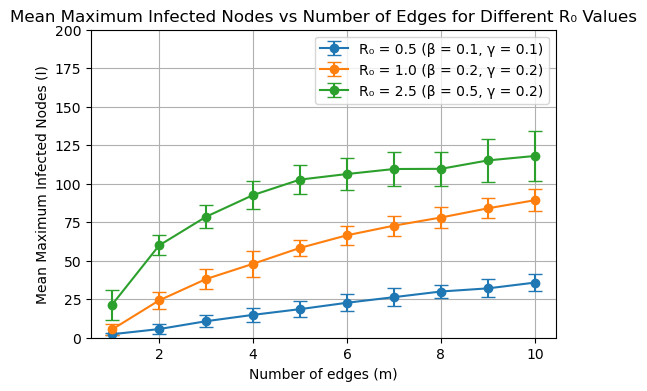

In [5]:
def ba_m_sweep(N, edges, beta, gamma, I0, t_span, num_runs):
    """."""

    mean_max_values = []
    std_max_values = []

    for m in edges:
        max_I_values = []
        
        for _ in range(num_runs):  
            _, y_data = barabasi_albert(N, m, beta, gamma, I0, t_span)
            
            I_values = [data['I'] for data in y_data]
            
            # Get the maximum infected value in the current run
            max_I = max(I_values) if I_values else 0
            max_I_values.append(max_I)
        
        mean_max_I = np.mean(max_I_values) if max_I_values else 0
        std_max_I = np.std(max_I_values) if max_I_values else 0
        
        mean_max_values.append(mean_max_I)
        std_max_values.append(std_max_I)
    
    return mean_max_values, std_max_values


def plot_ba_m_sweep(N, edges, beta_values, gamma_values, I0, t_span, num_runs):
    """."""

    plt.figure(figsize=(6, 4))
    
    for beta, gamma in zip(beta_values, gamma_values):
        mean_max_values, std_max_values = ba_m_sweep(N, edges, beta, gamma, I0, t_span, num_runs)
        
        R0 = beta/gamma
        label = f'R₀ = {R0:.1f} (β = {beta:.1f}, γ = {gamma:.1f})'
        
        plt.errorbar(edges, mean_max_values, yerr=std_max_values, fmt='-o', capsize=5, label=label)
    
    plt.xlabel("Number of edges (m)") 
    plt.ylabel("Mean Maximum Infected Nodes (I)")
    plt.title("Mean Maximum Infected Nodes vs Number of Edges for Different R₀ Values")
    plt.legend()  
    plt.grid(True)
    plt.ylim(0, N)  
    plt.show()


def ba_m_vs_R0(N, edges, I0, t_span, num_runs, R0_values, gamma_values):
    """."""

    beta_values = [R0 * gamma for R0, gamma in zip(R0_values, gamma_values)]
    plot_ba_m_sweep(N, edges, beta_values, gamma_values, I0, t_span, num_runs)


# ???
N = 200
edges = np.arange(1, 11, 1)
R0_values = [0.5, 1.0, 2.5] 
gamma_values = [0.1, 0.2, 0.2]
I0 = 0.01
t_span = 50
num_runs = 50

ba_m_vs_R0(N, edges, I0, t_span, num_runs, R0_values, gamma_values)

## 2. Watts-Strogatz
TODO introduction

### 2.1 Watts-Strogatz Network
TODO python explanation

- Each node is joined with its k nearest neighbors in a ring topology

In [ ]:
def watts_strogatz(N, k, p, beta, gamma, I0, t_span):
    """
    A Watts-Strogatz network model generates small-world networks with 
    short average path lengths between nodes and high cluster densities.
    """

    ws_graph = nx.watts_strogatz_graph(N, k, p)
    model = ep.SIRModel(ws_graph)

    config = mc.Configuration()
    config.add_model_parameter('beta', beta)
    config.add_model_parameter('gamma', gamma)
    config.add_model_parameter("fraction_infected", I0)
    model.set_initial_status(config)

    iterations = model.iteration_bunch(t_span)
    
    y_data = []

    for iteration in iterations:
        status = iteration['status']
        
        # Initialize counts
        S_count = 0
        I_count = 0
        R_count = 0
        
        # Count S, I, R based on status
        for _, state in status.items():
            if state == 0:
                S_count += 1
            elif state == 1:
                I_count += 1
            elif state == 2:
                R_count += 1
        
        y_data.append({'S': S_count, 'I': I_count, 'R': R_count})

    return iterations, y_data  # Return both iterations and status counts


N = 1000
k = 6    # Number of neighbors to rewire
p = 0.1    # Rewiring probability
t_span = 200

results = watts_strogatz(N, k, p, beta, gamma, I0, t_span)
print(results)

### 2.2 Watts-Strogatz Network parameter Sweep
TOD python (maybe merge with other sweeps)

In [ ]:
def ws_n_sweep(N, neighbors, p, beta, gamma, I0, t_span, num_runs):
    """."""

    mean_max_values = []
    std_max_values = []

    for n in neighbors:
        max_I_values = []
        
        for _ in range(num_runs):  
            _, y_data = watts_strogatz(N, n, p, beta, gamma, I0, t_span)
            
            I_values = [data['I'] for data in y_data]
            
            # Get the maximum infected value in the current run
            max_I = max(I_values) if I_values else 0
            max_I_values.append(max_I)
        
        mean_max_I = np.mean(max_I_values) if max_I_values else 0
        std_max_I = np.std(max_I_values) if max_I_values else 0
        
        mean_max_values.append(mean_max_I)
        std_max_values.append(std_max_I)
    
    return mean_max_values, std_max_values


def plot_ws_n_sweep(N, neighbors, p, beta_values, gamma_values, I0, t_span, num_runs):
    """."""

    plt.figure(figsize=(6, 4))
    
    for beta, gamma in zip(beta_values, gamma_values):
        
        mean_max_values, std_max_values = ws_n_sweep(N, neighbors, p, beta, gamma, I0, t_span, num_runs)
        
        R0 = beta/gamma
        label = f'R₀ = {R0:.1f} (β = {beta:.1f}, γ = {gamma:.1f})'
        
        plt.errorbar(neighbors, mean_max_values, yerr=std_max_values, fmt='-o', capsize=5, label=label)
    
    plt.xlabel("Number of Neighbors (n)") 
    plt.ylabel("Mean Maximum Infected Nodes (I)")
    plt.title("Mean Maximum Infected Nodes vs Number of Neighbors for Different R₀ Values")
    plt.legend()  
    plt.grid(True)
    plt.ylim(0, N)  
    plt.show()


def ws_n_vs_R0(N, neighbors, p, I0, t_span, num_runs, R0_values, gamma_values):
    """."""

    beta_values = [R0 * gamma for R0, gamma in zip(R0_values, gamma_values)]
    plot_ws_n_sweep(N, neighbors, p, beta_values, gamma_values, I0, t_span, num_runs)

    return


# Example Usage
N = 200
neighbors = np.arange(2, 22, 2)
p = 0.1 # Rewiring probability is fixed for now
R0_values = [0.5, 1.0, 2.5] 
gamma_values = [0.1, 0.2, 0.2]
I0 = 0.01
t_span = 50
num_runs = 50

ws_n_vs_R0(N, neighbors, p, I0, t_span, num_runs, R0_values, gamma_values)

## 3. Erdos-Reyni

TODO intro

### 3.1 Erdos-Reyni Network
TODO python

In [ ]:
def erdos_reyni(N, p, beta, gamma, I0, t_span):
    """ 
    A random network model that generates edges (paths) between nodes 
    randomly. We run sir once on this network.
    """
    
    # Construct E-R Network
    er_graph = nx.erdos_renyi_graph(N, p)

    model = ep.SIRModel(er_graph)

    config = mc.Configuration()
    config.add_model_parameter('beta', beta)
    config.add_model_parameter('gamma', gamma)
    config.add_model_parameter("fraction_infected", I0)

    model.set_initial_status(config)

    # Simulate the model
    iterations = model.iteration_bunch(t_span)

    # Extract number of S, I, R nodes for each iteration
    y_data = []  # List to hold S, I, R counts for each iteration

    for iteration in iterations:
        # Get the status of nodes
        status = iteration['status']
        
        # Initialize counts
        S_count = 0
        I_count = 0
        R_count = 0
        
        # Count S, I, R based on status
        for _, state in status.items():
            if state == 0:  # Susceptible
                S_count += 1
            elif state == 1:  # Infected
                I_count += 1
            elif state == 2:  # Recovered
                R_count += 1
        
        # Append counts to the list
        y_data.append({'S': S_count, 'I': I_count, 'R': R_count})

    return iterations, y_data  # Return both iterations and status counts


N = 1000  # Number of nodes
p = 0.01  # Probability for edge creation
t_span = 200

results = erdos_reyni(N, p, beta, gamma, I0, t_span)
print(results)

### 3.1 Erdos-Reyni Network Parameter Sweep

TODO explain

In [ ]:
def er_probability_sweep(N, probabilities, beta, gamma, I0, t_span, num_runs):
    """."""
    mean_max_values = []  
    std_max_values = []   

    for p in probabilities:
        max_I_values = []  
        
        for _ in range(num_runs):  
            _, y_data = erdos_reyni(N, p, beta, gamma, I0, t_span)
            
            I_values = [data['I'] for data in y_data]
            
            max_I = max(I_values) if I_values else 0
            max_I_values.append(max_I)
        
        mean_max_I = np.mean(max_I_values) if max_I_values else 0
        std_max_I = np.std(max_I_values) if max_I_values else 0
        
     
        mean_max_values.append(mean_max_I)
        std_max_values.append(std_max_I)
    
    return mean_max_values, std_max_values  


def plot_er_prob_sweep(N, probabilities, beta_values, gamma_values, I0, t_span, 
                       num_runs):
    """."""
    plt.figure(figsize=(6, 4))
    
    for beta, gamma in zip(beta_values, gamma_values):
        
        mean_max_values, std_max_values = er_probability_sweep(N, probabilities, beta, gamma, I0, t_span, num_runs)
        
        R0 = beta / gamma
        label = f'R₀ = {R0:.1f} (β = {beta:.1f}, γ = {gamma:.1f})'
        
        plt.errorbar(probabilities, mean_max_values, yerr=std_max_values, 
                     fmt='-o', capsize=5, label=label)
    
    plt.xlabel("Probability p") 
    plt.ylabel("Mean Maximum Infected Nodes (I)")
    plt.title("Mean Maximum Infected Nodes vs Probability for Different R₀ Values")
    plt.legend()  
    plt.grid(True)
    plt.ylim(0, N)  
    plt.show()


def er_prob_vs_R0(N, probabilities, I0, t_span, num_runs, R0_values, gamma_values):
    """."""
    beta_values = [R0 * gamma for R0, gamma in zip(R0_values, gamma_values)]
    
    plot_er_prob_sweep(N, probabilities, beta_values, gamma_values, I0, t_span, num_runs)


N = 200
probabilities = np.linspace(0.01, 0.1, 10)  
R0_values = [0.5, 1.0, 2.5]  
gamma_values = [0.1, 0.2, 0.2]  
I0 = 0.01
t_span = 50
num_runs = 50

er_prob_vs_R0(N, probabilities, I0, t_span, num_runs, R0_values, gamma_values)

## 4. Generating Networks and Examining Network Statistics

TODO MARVIN explain
also docstrings wrong format and too long, please refer to previous and document at the top

In [17]:
def gen_nets(nettype, N, m_vals, p_vals, r_vals, num_runs, k=5):

    """
    Generate networks of specified types and calculate degree statistics and clustering coefficients.

    Parameters:
    nettype (str): Type of the network to generate ('BA' for Barabási–Albert, 
                   'ER' for Erdös-Renyi, 'WS' for Watts-Strogatz).
    N (int): Number of nodes in the network.
    m_vals (list): List of m values for Barabási–Albert networks (number of edges to attach from a new node).
    p_vals (list): List of p values for Erdös-Renyi networks (probability of connecting two edges).
    r_vals (list): List of r values for Watts-Strogatz networks (probability of rewiring an existing edge).
    num_runs (int): Number of times to run the network generation to gather statistics.
    k (int, optional): Number of nearest neighbors each node is connected to in Watts-Strogatz networks. Default is 5.

    Returns:
    dict: A dictionary containing the following keys and their respective values:
        - 'mean_min_degrees': List of mean minimum degrees for each m/p/r value.
        - 'std_min_degrees': List of standard deviations of minimum degrees for each m/p/r value.
        - 'mean_max_degrees': List of mean maximum degrees for each m/p/r value.
        - 'std_max_degrees': List of standard deviations of maximum degrees for each m/p/r value.
        - 'mean_degrees': List of mean degrees for each m/p/r value.
        - 'std_degrees': List of standard deviations of degrees for each m/p/r value.
        - 'mean_clustering_coeffs': List of mean clustering coefficients for each m/p/r value.
        - 'std_clustering_coeffs': List of standard deviations of clustering coefficients for each m/p/r value.
    """
    
    mean_min_degrees = []
    std_min_degrees = []
    
    mean_max_degrees = []
    std_max_degrees = []
    
    mean_degrees = []
    std_degrees = []
    
    mean_clustering_coeffs = []  
    std_clustering_coeffs = []    

    if nettype == 'BA':

        for m in m_vals:
            min_degrees = []
            max_degrees = []
            degree_sums = []
            clustering_coeffs = []  

            for _ in range(num_runs):
                ba_net = nx.barabasi_albert_graph(N, m)
                
                degrees = [deg for _, deg in ba_net.degree()]

                min_degrees.append(min(degrees))
                max_degrees.append(max(degrees))
                degree_sums.append(np.mean(degrees))  
                clustering_coeffs.append(nx.average_clustering(ba_net))  
                
            mean_min_degrees.append(np.mean(min_degrees))
            std_min_degrees.append(np.std(min_degrees))
            
            mean_max_degrees.append(np.mean(max_degrees))
            std_max_degrees.append(np.std(max_degrees))

            mean_degrees.append(np.mean(degree_sums))
            std_degrees.append(np.std(degree_sums))

            mean_clustering_coeffs.append(np.mean(clustering_coeffs))  
            std_clustering_coeffs.append(np.std(clustering_coeffs))  

    elif nettype == 'ER':
        
        mean_min_degrees = []
        std_min_degrees = []
        
        mean_max_degrees = []
        std_max_degrees = []
        
        mean_degrees = []
        std_degrees = []
        
        mean_clustering_coeffs = []  
        std_clustering_coeffs = []    

        for p in p_vals:
            min_degrees = []
            max_degrees = []
            degree_sums = []
            clustering_coeffs = []  

            for _ in range(num_runs):
                er_net = nx.erdos_renyi_graph(N, p)
                
                degrees = [deg for _, deg in er_net.degree()]

                min_degrees.append(min(degrees))
                max_degrees.append(max(degrees))
                degree_sums.append(np.mean(degrees))  
                clustering_coeffs.append(nx.average_clustering(er_net))  
                
            mean_min_degrees.append(np.mean(min_degrees))
            std_min_degrees.append(np.std(min_degrees))
            
            mean_max_degrees.append(np.mean(max_degrees))
            std_max_degrees.append(np.std(max_degrees))

            mean_degrees.append(np.mean(degree_sums))
            std_degrees.append(np.std(degree_sums))

            mean_clustering_coeffs.append(np.mean(clustering_coeffs))  
            std_clustering_coeffs.append(np.std(clustering_coeffs))  
    
    elif nettype == 'WS':


        mean_min_degrees = []
        std_min_degrees = []
        
        mean_max_degrees = []
        std_max_degrees = []
        
        mean_degrees = []
        std_degrees = []
        
        mean_clustering_coeffs = []  
        std_clustering_coeffs = []    

        for r in r_vals:
            min_degrees = []
            max_degrees = []
            degree_sums = []
            clustering_coeffs = []  

            for _ in range(num_runs):
                
                ws_net = nx.watts_strogatz_graph(N, k, r)
                
                degrees = [deg for _, deg in ws_net.degree()]

                min_degrees.append(min(degrees))
                max_degrees.append(max(degrees))
                degree_sums.append(np.mean(degrees))  
                clustering_coeffs.append(nx.average_clustering(ws_net))  
                
            mean_min_degrees.append(np.mean(min_degrees))
            std_min_degrees.append(np.std(min_degrees))
            
            mean_max_degrees.append(np.mean(max_degrees))
            std_max_degrees.append(np.std(max_degrees))

            mean_degrees.append(np.mean(degree_sums))
            std_degrees.append(np.std(degree_sums))

            mean_clustering_coeffs.append(np.mean(clustering_coeffs))  
            std_clustering_coeffs.append(np.std(clustering_coeffs))  
            
    return {
        'mean_min_degrees': mean_min_degrees,
        'std_min_degrees': std_min_degrees,
        'mean_max_degrees': mean_max_degrees,
        'std_max_degrees': std_max_degrees,
        'mean_degrees': mean_degrees,
        'std_degrees': std_degrees,
        'mean_clustering_coeffs': mean_clustering_coeffs,  
        'std_clustering_coeffs': std_clustering_coeffs      
    }


def plot_degree_stats(nettype, N, m_vals, p_vals, r_vals, num_runs, k=5):
    """
    Plot degree statistics for generated networks of specified types.

    Parameters:
    nettype (str): Type of the network to plot ('BA' for Barabási–Albert, 
                   'ER' for Erdös-Renyi, 'WS' for Watts-Strogatz).
    N (int): Number of nodes in the network.
    m_vals (list): List of m values for Barabási–Albert networks (number of edges to attach from a new node).
    p_vals (list): List of p values for Erdös-Renyi networks (probability of connecting two edges).
    r_vals (list): List of r values for Watts-Strogatz networks (probability of rewiring an existing edge).
    num_runs (int): Number of times to run the network generation to gather statistics.
    k (int, optional): Number of nearest neighbors each node is connected to in Watts-Strogatz networks. Default is 5.

    Returns:
    None
    """
    
    results = gen_nets(nettype, N, m_vals, p_vals, r_vals, num_runs, k=5)
    
    mean_min_degrees = results['mean_min_degrees']
    std_min_degrees = results['std_min_degrees']
    mean_max_degrees = results['mean_max_degrees']
    std_max_degrees = results['std_max_degrees']
    mean_degrees = results['mean_degrees']
    std_degrees = results['std_degrees']
    
    plt.figure(figsize=(8, 4))

    

    if nettype == 'BA':
        
        plt.errorbar(m_vals, mean_min_degrees, yerr=std_min_degrees, fmt='o', capsize=5, label='Mean Min Degree', color='blue')

        plt.errorbar(m_vals, mean_max_degrees, yerr=std_max_degrees, fmt='o', capsize=5, label='Mean Max Degree', color='green')

        plt.errorbar(m_vals, mean_degrees, yerr=std_degrees, fmt='o', capsize=5, label='Mean Degree', color='red')



        plt.xlabel("m (Number of edges to attach from a new node)")
        plt.title("Mean Min, Max, and Overall Degree vs m in Barabási–Albert Networks")
        

    elif nettype == 'ER':
        plt.errorbar(p_vals, mean_min_degrees, yerr=std_min_degrees, fmt='o', capsize=5, label='Mean Min Degree', color='blue')

        plt.errorbar(p_vals, mean_max_degrees, yerr=std_max_degrees, fmt='o', capsize=5, label='Mean Max Degree', color='green')

        plt.errorbar(p_vals, mean_degrees, yerr=std_degrees, fmt='o', capsize=5, label='Mean Degree', color='red')


        plt.xlabel("p (Probability of connecting two edges)")
        plt.title("Mean Min, Max, and Overall Degree vs p in Erdös–Renyi Networks")

    elif nettype == 'WS':
        plt.errorbar(r_vals, mean_min_degrees, yerr=std_min_degrees, fmt='o', capsize=5, label='Mean Min Degree', color='blue')

        plt.errorbar(r_vals, mean_max_degrees, yerr=std_max_degrees, fmt='o', capsize=5, label='Mean Max Degree', color='green')

        plt.errorbar(r_vals, mean_degrees, yerr=std_degrees, fmt='o', capsize=5, label='Mean Degree', color='red')


        plt.xlabel("r (Probability of rewiring an exisint edge)")
        plt.title("Mean Min, Max, and Overall Degree vs r in Watts-Strogatz Networks")


    plt.ylabel("Degree")
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_clustering_stats(nettype, N, m_vals, p_vals, r_vals, num_runs, k=5):
    """
    Plot clustering coefficient statistics for generated networks of specified types.

    Parameters:
    nettype (str): Type of the network to plot ('BA' for Barabási–Albert, 
                   'ER' for Erdös-Renyi, 'WS' for Watts-Strogatz).
    N (int): Number of nodes in the network.
    m_vals (list): List of m values for Barabási–Albert networks (number of edges to attach from a new node).
    p_vals (list): List of p values for Erdös-Renyi networks (probability of connecting two edges).
    r_vals (list): List of r values for Watts-Strogatz networks (probability of rewiring an existing edge).
    num_runs (int): Number of times to run the network generation to gather statistics.
    k (int, optional): Number of nearest neighbors each node is connected to in Watts-Strogatz networks. Default is 5.

    Returns:
    None: This function generates and displays a plot of the clustering coefficients.
    """
    
    results = gen_nets(nettype, N, m_vals, p_vals, r_vals, num_runs, k=5)
    mean_clustering_coeffs = results['mean_clustering_coeffs']
    std_clustering_coeffs = results['std_clustering_coeffs']


    plt.figure(figsize=(8, 4))

    
    
    if nettype == 'BA':
        plt.xlabel("m (Number of edges to attach from a new node)")
        plt.title("Mean Clustering Coefficient vs m in Barabási–Albert Networks")
        bar_width = 0.4  
        bar_positions = np.arange(len(m_vals))  
        plt.bar(bar_positions, mean_clustering_coeffs, yerr=std_clustering_coeffs, width=bar_width, alpha=0.6, color='orange', label='Mean Clustering Coefficient')
        plt.xticks(bar_positions + bar_width / 2, m_vals)  
    
    elif nettype == 'ER':
        plt.xlabel("p (Probability of connecting two edges)")
        plt.title("Mean Clustering Coefficient vs p in Erdös-Renyi Networks")
        bar_width = 0.4  
        bar_positions = np.arange(len(p_vals))  
        plt.bar(bar_positions, mean_clustering_coeffs, yerr=std_clustering_coeffs, width=bar_width, alpha=0.6, color='orange', label='Mean Clustering Coefficient')
        plt.xticks(bar_positions + bar_width / 2, np.round(p_vals, 2)) 

    elif nettype == 'WS':
        plt.xlabel("r (Probability of rewiring an exising edge)")
        plt.title("Mean Clustering Coefficient vs r in Watts-Strogatz Networks")
        bar_width = 0.4  
        bar_positions = np.arange(len(r_vals))  
        plt.bar(bar_positions, mean_clustering_coeffs, yerr=std_clustering_coeffs, width=bar_width, alpha=0.6, color='orange', label='Mean Clustering Coefficient')
        plt.xticks(bar_positions + bar_width / 2, np.round(r_vals, 1)) 



    plt.ylabel("Clustering Coefficient")
    plt.legend()
    plt.grid(True)
    plt.show()


N = 300
# NOTe FRED: same for sweeps
m_vals = np.arange(2, 23, 2)
p_vals = np.linspace(0.01, 0.1, 10)
r_vals = np.linspace(0.1, 0.9, 10)
num_runs = 50

### 4.1 BA Network Results

Different title?

In [ ]:
plot_degree_stats('BA', N, m_vals, p_vals, r_vals, num_runs)
plot_clustering_stats('BA', N, m_vals, p_vals, r_vals, num_runs)

### 4.2 ER Network Results

In [ ]:
plot_degree_stats('ER', N, m_vals, p_vals, r_vals, num_runs)
plot_clustering_stats('ER', N, m_vals, p_vals, r_vals, num_runs)

### 4.3 WS Network Results

In [ ]:
plot_degree_stats('WS', N, m_vals, p_vals, r_vals, num_runs)
plot_clustering_stats('WS', N, m_vals, p_vals, r_vals, num_runs)

## 5. Dynamic Vaccination Campaign

To Do:
1. load in sociopatterns dataset (NDlib and network X)
    If i open the data in excel, the data structure is such that the first row and column signify the nodes. nodes from 1 to 374. All cells in between signify if there is an edge between the nodes. if the number is > 0 it means there is an edge, we can negate how high since that is the weight which we are not looking at right now (identity matrix)

    1 means infected, 0 means susceptible, 2 means recovered

    In NDlib 'Recovered' is 'Removed'

2. can we test and vaccinate at the same iteration or not
    we assume we can!

3. visualize the data

4. Add test accuracy!

5. we think people infected, they maynot be, dont put their status to 2, if 1 not into 2

"but you can only discover the disease status of a node after a test"
test can show antibodies

'status' is something i added to the nodes of known_graph and are not inherently in graph, to access the node statuses of the graph, access the status through model instead!

### 5.1 Random Null Strategy

TODO FRED Explain

Seperate into multiple markdowns

In [ ]:

def load_sociopatterns():
    """
    Loads and initiates the csv file containing sociopattern information.
    Initiates two graphs, one for actual data and one simulating what we
    know about the data. """

    edge_list = pd.read_csv("transmission_network.csv", delimiter=';', 
                            index_col=0)

    graph = nx.Graph()
    graph_known = nx.Graph()

    # Adds all nodes to the graph
    graph.add_nodes_from(edge_list.index.tolist())
    graph_known.add_nodes_from(edge_list.index.tolist())

    # Adds edges between nodes if their weight is higher than 0
    for node_i, row in edge_list.iterrows():
        for node_j, value in row.items():
            if value > 0:
                graph.add_edge(int(node_i), int(node_j))
                graph_known.add_edge(int(node_i), int(node_j))

    return graph, graph_known
    

def initiate_model(graph, graph_known, beta, gamma):
    """" 
    Initiates SIR model on the graph (real world) and sets the status of 
    known graph to everybody as susceptible.
    """

    model = ep.SIRModel(graph)
    config = mc.Configuration()
    config.add_model_parameter('beta', beta)
    config.add_model_parameter('gamma', gamma)

    # Initiates states for all nodes in the known graph to susceptible
    for node in graph_known.nodes:
        graph_known.nodes[node]['status'] = 0

    # Randomly assigns 5 nodes to get infected
    infected = 5
    infected_nodes = (np.random.choice(graph.nodes(), size=infected, 
                                       replace=False)).tolist()
    config.add_model_initial_configuration('Infected', infected_nodes)
    model.set_initial_status(config)

    return model, graph_known


def update_sir_model(model, graph, iterations):
    """
    Runs the SIR model for iterations number of times.
    """
    model.iteration_bunch(iterations) 

    return model, graph


def test_nodes_random(model, graph_known, tests, vac_pool, accuracy):
    """Tests if a node is infected. Should only test people you know are 
    not currently removed or infected."""
    
    available_nodes = [] 

  
    # Adds people that are susceptible to available nodes
    for node in graph_known.nodes:
        if graph_known.nodes[node]['status'] == 0:
            available_nodes.append(node)

    # Resets number of tests if there are not enough available nodes
    if len(available_nodes) == 0:
        return
    
    elif len(available_nodes) < tests:
        tests = available_nodes
    
    # Selects 'tests' number of nodes randomly
    # If replace is false, no one will be tested twice in this iteration
    tested_nodes = (np.random.choice(available_nodes, size=tests, 
                                     replace=False)).tolist()

    # Updates the status of the tested nodes on the known graph
    for node in tested_nodes:
        status = model.status[node]

        # Write code for test accuracy here
        # accuracy as a variable to influence chance of test reading as the wrong one
        # Some people are approaching this as a S reading as I and I reading as S and saying R is always correct
        if status == 0:
            status = np.random.choice([status, 1], p=accuracy)
        elif status == 1:
            status = np.random.choice([status, 0], p=accuracy)
            
        graph_known.nodes[node]['status'] = status

        # Adds to susceptible vaccination pool if not already there
        if status == 0 and node not in vac_pool:
            vac_pool.append(node)

        elif status != 0 and node in vac_pool:
            vac_pool.remove(node)

    return graph_known, vac_pool, tests


def vac_nodes_random(model, graph_known, vac_budget, vac_pool):
    """. Only vacc sus people that you know of."""

    # If there are not enough Susceptible people, reset the vaccination budget
    if len(vac_pool) < vac_budget:
        vac_budget = len(vac_pool)

    # Randomly choose susceptible people to vaccinate
    vac_nodes = (np.random.choice(vac_pool, size=vac_budget, 
                                  replace=False)).tolist()

    # Update all statuses of vaccinated nodes to 'Removed'
    for node in vac_nodes:
        graph_known.nodes[node]['status'] = 2

        # Can only remove people who are not currently infected or removed
        if model.status[node] == 0:
            model.status[node] = 2

        # Remove vaccinated from vaccination pool
        vac_pool = [node for node in vac_pool if node not in vac_nodes]

    return model, graph_known, vac_pool


def random_campaign(test_max, beta, gamma, t_span):
    """
    Runs the random network model null simulation. """

    total_tests = 200
    t = 0
    vac_pool = []
    iterations = 1
    vac_budget = 5
    accuracy = [0.75, 0.25]

    results = []

    # Loads and initializes all data, makes graph of known statuses 
    graph, graph_known = load_sociopatterns()
    model, graph_known = initiate_model(graph, graph_known, beta, gamma)

    # Tests, vaccinates and runs sir for t_span amount of iterations
    while t <= t_span:

        # Can only perform tests if there are tests left in the test budget
        if total_tests > 0:
            graph_known, vac_pool, tests = test_nodes_random(model, graph_known, 
                                                             test_max, vac_pool, accuracy)
            total_tests -= tests
            
        model, graph_known, vac_pool = vac_nodes_random(model, graph_known, 
                                                        vac_budget, vac_pool)
        update_sir_model(model, graph, iterations)

        # Store the current state of the model
        infected_count = sum(1 for node in model.status if model.status[node] == 1)
        susceptible_count = sum(1 for node in model.status if model.status[node] == 0)
        removed_count = sum(1 for node in model.status if model.status[node] == 2)

        # Append results for the current time step
        results.append({
            'time': t,
            'infected': infected_count,
            'susceptible': susceptible_count,
            'removed': removed_count,
            'vaccination_pool_size': len(vac_pool),
            'total_tests_remaining': total_tests,
        })

        t += 1

    return results


def simulate_random_campaign(test_max, beta, gamma, t_span, num_runs):

    max_I_vals = []

    for _ in range(num_runs):

        results = results = random_campaign(test_max, beta, gamma, t_span)
        infected_counts = [entry['infected'] for entry in results]
        max_I = max(infected_counts)
        max_I_vals.append(max_I)
    
    mean_max_I = np.mean(max_I_vals)
    std_max_I = np.std(max_I_vals)

    return max_I_vals, mean_max_I, std_max_I

test_max = 5
beta = 0.05
gamma = 0.01
t_span = 10
num_runs = 5

simulate_random_campaign(test_max, beta, gamma, t_span, num_runs)

### 5.2 Vaccinating Largest Hubs First Strategy

TODO MARVIN explain

In [78]:
def sort_nodes():
    """
    Returns a list of nodes sorted from high to low degrees.
    """
   
    graph, _ = load_sociopatterns()
    nodes = [(node, graph.degree(node)) for node in graph]
    sorted_nodes = sorted(nodes, key=lambda x: x[1], reverse=True)

    return sorted_nodes
    

def test_hubs(model, graph_known, tests, vac_pool):
    """Tests if a node is infected. Should only test people you know are 
    not currently removed or infected."""

    sorted_nodes = sort_nodes()
    available_nodes = [] 
  
    # Adds people that are susceptible to available nodes
    for node in graph_known.nodes:
        if graph_known.nodes[node]['status'] == 0:
            available_nodes.append(node)

    # Resets number of tests if there are not enough available nodes
    if len(available_nodes) == 0:
        return
    
    elif len(available_nodes) < tests:
        tests = available_nodes
    
    top_nodes = [node for node, _ in sorted_nodes if node in 
                 available_nodes][:tests]
    
    for node in top_nodes:
        status = model.status[node]

        # Update known graph with the actual status from the model
        graph_known.nodes[node]['status'] = status

        # Adds to susceptible vaccination pool if the node is susceptible
        if status == 0 and node not in vac_pool:
            vac_pool.append(node)

        elif status != 0 and node in vac_pool:
            vac_pool.remove(node)

    return graph_known, vac_pool, tests


def vac_hubs(model, graph_known, vac_budget, vac_pool):
    """Vaccinate largest (susceptible) hubs."""

    # If there are not enough Susceptible people, reset the vaccination budget
    if len(vac_pool) < vac_budget:
        vac_budget = len(vac_pool)

    # Choose largest susceptible hubs
    vac_nodes = vac_pool[0:vac_budget + 1]

    # Update all statuses of vaccinated nodes to 'Removed'
    for node in vac_nodes:
        graph_known.nodes[node]['status'] = 2

        # Can only remove people who are not currently infected or removed
        if model.status[node] == 0:
            model.status[node] = 2

        # Remove vaccinated from vaccination pool
        vac_pool = [node for node in vac_pool if node not in vac_nodes]

    return model, graph_known, vac_pool


def hub_campaign(test_max, beta, gamma, t_span):
    """
    Runs the random network model null simulation. """

    total_tests = 200
    t = 0
    vac_pool = []
    iterations = 1
    results = []

    # Loads and initializes all data, makes graph of known statuses 
    graph, graph_known = load_sociopatterns()
    model, graph_known = initiate_model(graph, graph_known, beta, gamma)

    # Tests, vaccinates and runs sir for t_span amount of iterations
    while t <= t_span:

        # Can only perform tests if there are tests left in the test budget
        if total_tests > 0:
            graph_known, vac_pool, tests = test_hubs(model, graph_known, 
                                                     test_max, vac_pool)
            total_tests -= tests
            
        model, graph_known, vac_pool = vac_hubs(model, graph_known, 
                                                vac_budget, vac_pool)
        
        update_sir_model(model, graph, iterations)

        # Store the current state of the model
        infected_count = sum(1 for node in model.status if model.status[node] == 1)
        susceptible_count = sum(1 for node in model.status if model.status[node] == 0)
        removed_count = sum(1 for node in model.status if model.status[node] == 2)

        # Append results for the current time step
        results.append({
            'time': t,
            'infected': infected_count,
            'susceptible': susceptible_count,
            'removed': removed_count,
            'vaccination_pool_size': len(vac_pool),
            'total_tests_remaining': total_tests,
        })

        t += 1

    return results


def simulate_hub_campaign(test_max, beta, gamma, t_span, num_runs):
    """."""

    max_I_vals = []

    for _ in range(num_runs):

        results = hub_campaign(test_max, beta, gamma, t_span)
        infected_counts = [entry['infected'] for entry in results]
        max_I = max(infected_counts)
        max_I_vals.append(max_I)
    
    mean_max_I = np.mean(max_I_vals)
    std_max_I = np.std(max_I_vals)

    return max_I_vals, mean_max_I, std_max_I

### 5.3 Vaccination Campaign Results (Including T-Test)

TODO EXPLAIN

In [79]:
def show_campaign_results(test_max, beta, gamma, t_span, num_runs):
    """
    Plots the mean maximum infected counts for both random and hub 
    campaigns with their standard deviations.
    """
    
    _, mean_max_random, std_max_random = simulate_random_campaign(
        test_max, beta, gamma, t_span, num_runs)
    
    _, mean_max_hub, std_max_hub = simulate_hub_campaign(
        test_max, beta, gamma, t_span, num_runs)

    x_labels = ['Random', 'Hub']  
    means = [mean_max_random, mean_max_hub]  
    std_devs = [std_max_random, std_max_hub]  
    
    plt.errorbar(x=np.arange(len(means)), y=means, yerr=std_devs, fmt='o', 
                 capsize=5, color='blue', alpha=0.7, label='Mean Max Infected Counts')
    
    plt.xticks(np.arange(len(x_labels)), x_labels)  # Set x-tick labels
    plt.title('Mean Maximum Infected Counts with Standard Deviation')
    plt.ylabel('Count of Infected Individuals')
    plt.grid(axis='y')
    plt.legend()
    plt.tight_layout()  # Adjust layout to make room for labels
    plt.show()


def t_test(test_max, beta, gamma, t_span, num_runs):
    """."""

    max_vals_random, _, _ = simulate_random_campaign(
        test_max, beta, gamma, t_span, num_runs)
    
    max_vals_hub, _, _ = simulate_hub_campaign(
        test_max, beta, gamma, t_span, num_runs)
    
    t_stat, p_val = stats.ttest_ind(max_vals_random, max_vals_hub)

    return t_stat, p_val

In [ ]:
t_span = 100
beta = 0.3
gamma = 0.1
test_max = 5
vac_budget = 5
test_accuracy = 1.0
num_runs = 10



plot_campaign_results(test_max, beta, gamma, t_span, num_runs)

t_stat, p_val = t_test(test_max, beta, gamma, t_span, num_runs)

print("t-statistic:", t_stat)
print("p-value:", p_val)

### 5.4 Highest Score First Strategy

TODO fred explain

In [ ]:
def calc_closeness(graph):
    """."""
    # Closeness centrality
    # How close node to all other nodes
    closeness = nx.closeness_centrality(graph)
    sort_clo = sorted(closeness.items(), key=lambda x: x[1], reverse=True)
    clo_scores = assign_scores(sort_clo)

    return clo_scores


def calc_betweenness(graph):
    """."""
    # betweenness
    # Node on path of other nodes
    betweenness = nx.betweenness_centrality(graph)
    sort_bet = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)
    bet_scores = assign_scores(sort_bet)

    return bet_scores


def calc_adjecency(graph):
    """."""
    # How many neighbors
    adjecency = dict(graph.degree())
    sort_adj = sorted(adjecency.items(), key=lambda x: x[1], reverse=True)
    adj_scores = assign_scores(sort_adj)
    
    return adj_scores


def assign_scores(sortedlist):
    """."""
    # assigns scores to nodes on a list based on their maximum value (scaled)
    # Top list get top scores

    value_max = sortedlist[0][1]
    score_dict = {}

    for node, score in sortedlist:
        score_dict[node] = np.round((score/value_max), 4)
    
    return score_dict


def calc_total_scores(graph):
    """."""
    # Calculates total scores
    score_adj = calc_adjecency(graph)
    score_bet = calc_betweenness(graph)
    score_clo = calc_closeness(graph)
    score_total = {}
    
    for node in score_adj:
        score_total[node] = np.round(score_adj[node] + score_bet.get(node, 0) + score_clo.get(node, 0), 4)

    sorted_scores = dict(sorted(score_total.items(), key=lambda x: x[1], reverse=True))
     
    return sorted_scores


def test_nodes_score(tests, scores, graph_known, model, vac_pool, infected, accuracy):
    """Tests if a node is infected. Should only test people you know are 
    not currently removed or infected."""

    test_nodes = []
    tested_nodes = []

    for node, _ in scores.items():
        # find neighbors of known infected add to list
        if graph_known.nodes[node]['status'] == 1:
            neighbors_list = [n for n in graph_known.neighbors(node) 
                              if graph_known.nodes[n]['status'] == 0]
            
            for n in neighbors_list:
                if n not in test_nodes:
                    test_nodes.append(n)
                
                # Scores get updated based on infected neighbor (only once per infection)
                if node in infected:
                    scores[n] += scores[node]

            # Remove an infected node from this list after all neighbors' scores have been updated
            if node in infected: 
                infected.remove(node)

        # Add susceptible known to list
        elif graph_known.nodes[node]['status'] == 0:
            test_nodes.append(node)

    # Sorts the nodes to test based on their score
    test_nodes = sorted(test_nodes, key=lambda x: scores.get(x, 0), reverse=True)

    for node in test_nodes[:tests]:
        status = model.status[node]

        # Status may change according to the test accuracy 
        if status == 0:
            status = np.random.choice([status, 1], p=accuracy)
        elif status == 1:
            status = np.random.choice([status, 0], p=accuracy)
            
        graph_known.nodes[node]['status'] = status
        tested_nodes.append(node)

        # Add or remove nodes to their corresponding list
        if status == 0 and node not in vac_pool:
            vac_pool.append(node)
        elif status == 1 and node in vac_pool:
            vac_pool.remove(node)
            infected.append(node)
        elif status == 2 and node in vac_pool:
            vac_pool.remove(node)
    
    #sort the vac_pool based on their score 
    vac_pool = sorted(vac_pool, key=lambda x: scores.get(x, 0), reverse=True)

    return graph_known, vac_pool, tested_nodes, infected


#Remove function later
def show_status(model, graph_known, vaccinated_nodes, tested_nodes):
    # 1. Known counts for infected, removed, and susceptible
    known_infected = sum(1 for node in graph_known.nodes if graph_known.nodes[node]['status'] == 1)
    known_removed = sum(1 for node in graph_known.nodes if graph_known.nodes[node]['status'] == 2)
    known_susceptible = sum(1 for node in graph_known.nodes if graph_known.nodes[node]['status'] == 0)
    
    print(f"Known - Infected: {known_infected}, Removed: {known_removed}, Susceptible: {known_susceptible}")
    
    # 2. Actual counts from the model for infected, removed, and susceptible
    actual_infected = sum(1 for node in model.status if model.status[node] == 1)
    actual_removed = sum(1 for node in model.status if model.status[node] == 2)
    actual_susceptible = sum(1 for node in model.status if model.status[node] == 0)
    
    print(f"Actual - Infected: {actual_infected}, Removed: {actual_removed}, Susceptible: {actual_susceptible}")
    
    # 3. Vaccinated count this round
    print(f"Vaccinated this round: {len(vaccinated_nodes)}")
    
    # 4. Tested count this round
    print(f"Tested this round: {len(tested_nodes)}")  
    return


def vac_nodes_score(model, graph_known, vac_budget, vac_pool, scores):
    """. Only vacc sus people that you know of."""
    vaccinated = []

    # If there are not enough Susceptible people, reset the vaccination budget
    if len(vac_pool) < vac_budget:
        add_to_pool = vac_budget - len(vac_pool)

        candidates = [node for node in graph_known.nodes 
                      if graph_known.nodes[node]['status'] == 0 
                      and node not in vac_pool]
        sorted_c = sorted(candidates, key=lambda x: scores.get(x, 0), reverse=True)

        for c in sorted_c[:add_to_pool]:
            vac_pool.append(c)

        vac_budget = len(vac_pool)

    # Choose largest susceptible hubs
    #To Marvin: you had a +1 but you vaccinated an extra person like that?
    vac_nodes = vac_pool[0:vac_budget]

    # Update all statuses of vaccinated nodes to 'Removed'
    for node in vac_nodes:
        graph_known.nodes[node]['status'] = 2

        # Can only remove people who are not currently infected or removed
        if model.status[node] == 0:
            model.status[node] = 2

        # Remove vaccinated from vaccination pool
        vac_pool.remove(node)
        vaccinated.append(node)

    return model, graph_known, vac_pool, vaccinated


def score_campaign(test_max, beta, gamma, t_span):
    """
    Runs the random network model null simulation. """

    total_tests = 200
    t = 0
    vac_pool = []
    iterations = 1
    vac_budget = 5
    accuracy = [0.75, 0.25]
    infected = []

    results = []

    # Loads and initializes all data, makes a graph of the known statuses.
    graph, graph_known = load_sociopatterns()
    model, graph_known = initiate_model(graph, graph_known, beta, gamma)

    # Assign scores to nodes based on adjecency, betweenness and closeness.
    scores_dict = calc_total_scores(graph)

    while t <= t_span:
        if total_tests > 0:
            graph_known, vac_pool, tested_nodes, infected = test_nodes_score(test_max, scores_dict, graph_known, model, vac_pool, infected, accuracy)
            
        model, graph_known, vac_pool, vaccinated = vac_nodes_score(model, graph_known, vac_budget, vac_pool, scores_dict)
        #show_status(model, graph_known, vaccinated, tested_nodes)
        update_sir_model(model, graph, iterations)

        total_tests -= test_max

        # Reset tests per iteration if the budget is too small.
        if total_tests < test_max:
            test_max = total_tests

        # Store the current state of the model
        infected_count = sum(1 for node in model.status if model.status[node] == 1)
        susceptible_count = sum(1 for node in model.status if model.status[node] == 0)
        removed_count = sum(1 for node in model.status if model.status[node] == 2)

        # Append results for the current time step
        results.append({
            'time': t,
            'infected': infected_count,
            'susceptible': susceptible_count,
            'removed': removed_count,
            'vaccination_pool_size': len(vac_pool),
            'total_tests_remaining': total_tests,
        })

        t += 1

    return results


def simulate_score_campaign(test_max, beta, gamma, t_span, num_runs):
    """."""

    max_I_vals = []

    for _ in range(num_runs):

        results = score_campaign(test_max, beta, gamma, t_span)
        infected_counts = [entry['infected'] for entry in results]
        max_I = max(infected_counts)
        max_I_vals.append(max_I)
    
    mean_max_I = np.mean(max_I_vals)
    std_max_I = np.std(max_I_vals)

    return max_I_vals, mean_max_I, std_max_I


test_max = 10
beta = 0.05
gamma = 0.01
t_span = 50
num_runs = 5

simulate_score_campaign(test_max, beta, gamma, t_span, num_runs)

In [ ]:
def show_campaign_results(test_max, beta, gamma, t_span, num_runs):
    """
    Plots the mean maximum infected counts for both random and hub 
    campaigns with their standard deviations.
    """
    
    _, mean_max_random, std_max_random = simulate_random_campaign(
        test_max, beta, gamma, t_span, num_runs)
    
    _, mean_max_hub, std_max_hub = simulate_score_campaign(
        test_max, beta, gamma, t_span, num_runs)

    x_labels = ['Random', 'Hub']  
    means = [mean_max_random, mean_max_hub]  
    std_devs = [std_max_random, std_max_hub]  

    
    plt.errorbar(x=np.arange(len(means)), y=means, yerr=std_devs, fmt='o', 
                 capsize=5, color='blue', alpha=0.7, label='Mean Max Infected Counts')

    
    plt.xticks(np.arange(len(x_labels)), x_labels)  # Set x-tick labels
    plt.title('Mean Maximum Infected Counts with Standard Deviation')
    plt.ylabel('Count of Infected Individuals')
    plt.grid(axis='y')
    plt.legend()
    plt.tight_layout()  # Adjust layout to make room for labels
    plt.show()


def t_test(test_max, beta, gamma, t_span, num_runs):

    max_vals_random, _, _ = simulate_random_campaign(
        test_max, beta, gamma, t_span, num_runs)
    
    max_vals_hub, _, _ = simulate_score_campaign(
        test_max, beta, gamma, t_span, num_runs)
    
    t_stat, p_val = stats.ttest_ind(max_vals_random, max_vals_hub)

    return t_stat, p_val

test_max = 10
beta = 0.05
gamma = 0.01
t_span = 50
num_runs = 10

show_campaign_results(test_max, beta, gamma, t_span, num_runs)
    

